In [1]:
from __future__ import division
from __future__ import print_function

import time
import argparse
import numpy as np

import torch
import torch.optim as optim

from utils import load_data,normalize,toy_data,norm_embed,nmi_score

import matplotlib.pyplot as plt 

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from layers import GraphConvolution, InnerProduct
from utils import norm_embed
import torch

In [3]:
class GNN(nn.Module):
    
    def __init__(self, batch_size, nfeat, nhid, ndim, mu0, sigma0):
        super(GNN, self).__init__()

        self.gc1 = GraphConvolution(batch_size, nfeat, nhid, mu0, sigma0, scale=False)
        self.embeddings = GraphConvolution(batch_size, nhid, 2*ndim, mu0, sigma0, scale=True)
        self.reconstructions = InnerProduct(2*ndim)

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = self.embeddings(x, adj)
        x = norm_embed(x)
        mu = F.relu(self.reconstructions(x))
        return mu
    

In [4]:
np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False,precision=8)

In [5]:
# Training settings
parser = argparse.ArgumentParser()
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Disables CUDA training.')
parser.add_argument('--fastmode', action='store_true', default=False,
                    help='Validate during training pass.')
parser.add_argument('--seed', type=int, default=426, help='Random seed.')
parser.add_argument('--epochs', type=int, default=10000,
                    help='Number of epochs to train.')
parser.add_argument('--lr', type=float, default=0.001,
                    help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=10e-8,
                    help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=16,
                    help='Number of hidden units.')
parser.add_argument('--ndim', type=int, default=2,
                    help='Embeddings dimension.')

args = parser.parse_args(args=[])
args.cuda = not args.no_cuda and torch.cuda.is_available()

In [6]:
if 1:
    # Taxi Dataset Graph
    adj = load_data()
    #adj = load_data(daily=True)
else:
    #Toy Example Graph
    adj = toy_data()

In [7]:
def GraphNeuralNet(adj,dim):
    
    # Set the random seed
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.cuda:
        torch.cuda.manual_seed(args.seed)
        
    args.ndim = dim
    
    adj_norm = normalize(adj)

    adj = torch.FloatTensor(np.array(adj))
    
    # loss function
    criterion = torch.nn.GaussianNLLLoss()

    # Model and optimizer
    model = GNN(batch_size=adj_norm.shape[0],
                nfeat=adj_norm.shape[1],
                nhid=args.hidden,
                ndim=args.ndim,
                mu0=adj.mean(),
                sigma0=adj.std())

    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    model.embeddings.register_forward_hook(get_activation('embeddings'))
    

    features = torch.FloatTensor(torch.eye(adj.shape[1]))
    features = features.reshape((1,adj.shape[1],adj.shape[1]))
    features = features.repeat(adj.shape[0], 1, 1)

    if args.cuda:
        model.cuda()
        features = features.cuda()
        adj = adj.cuda()
        adj_norm = adj_norm.cuda()


    # Train model
    t_total = time.time()
    
    # NULL Model
    mu0 = adj.mean()*torch.ones(adj.shape[1:])
    sigma0 = adj.std()*torch.ones(adj.shape[1:])
    with torch.no_grad():
        loss0 = criterion(torch.flatten(adj), torch.flatten(mu0), torch.flatten(torch.square(sigma0)))

    optimizer = optim.Adam(model.parameters(),
                           lr=args.lr, weight_decay=args.weight_decay)

    for epoch in range(args.epochs):

        t = time.time()
        model.train()
        optimizer.zero_grad()
        mu = model(features, adj_norm)
        
        with torch.no_grad():
            mse = torch.nn.MSELoss()
            mseloss = mse(torch.flatten(mu),torch.flatten(adj_norm))
            sig = torch.sqrt(mseloss)
        sigma = sig * torch.ones(adj_norm.shape,requires_grad=True)
        
        loss = criterion(torch.flatten(adj), torch.flatten(mu), torch.flatten(torch.square(sigma))) 
        loss.backward()
        optimizer.step()

        if epoch == 0:
            best_loss = loss
        else:
            if loss < best_loss:
                best_loss = loss

        if epoch % 1000 == 0:
            print('Epoch: {:04d}'.format(epoch + 1),
                  'loss: {:.8f}'.format(best_loss.item()),
                  'time: {:.4f}s'.format(time.time() - t))
            

    print("Optimization Finished!")
    print("Total time elapsed: {:.4f}s".format(time.time() - t_total))
    
    return adj,mu,best_loss.item(),loss0


In [8]:
losses = []
nmi = []
dims = [x for x in range(1,15)]
for dim in dims:
    adj_norm,mu,loss,loss0 = GraphNeuralNet(adj=adj,dim=dim)
    losses.append(loss)
    nmi.append(nmi_score(adj_norm[0],mu.reshape(adj_norm.shape[1:]).detach()))

Epoch: 0001 loss: 3721641.25000000 time: 0.0040s
Epoch: 1001 loss: 27.80582047 time: 0.0040s
Epoch: 2001 loss: 15.72799015 time: 0.0040s
Epoch: 3001 loss: 12.97514057 time: 0.0000s
Epoch: 4001 loss: 11.97752094 time: 0.0000s
Epoch: 5001 loss: 11.53821468 time: 0.0010s
Epoch: 6001 loss: 11.31738186 time: 0.0020s
Epoch: 7001 loss: 11.19578457 time: 0.0010s
Epoch: 8001 loss: 11.12407303 time: 0.0010s
Epoch: 9001 loss: 11.08464336 time: 0.0020s
Optimization Finished!
Total time elapsed: 18.5210s
Epoch: 0001 loss: 930052.00000000 time: 0.0020s
Epoch: 1001 loss: 14.97016239 time: 0.0010s
Epoch: 2001 loss: 12.10234642 time: 0.0010s
Epoch: 3001 loss: 11.48444462 time: 0.0020s
Epoch: 4001 loss: 11.25874901 time: 0.0020s
Epoch: 5001 loss: 11.15270519 time: 0.0020s
Epoch: 6001 loss: 11.09746170 time: 0.0020s
Epoch: 7001 loss: 11.06853104 time: 0.0020s
Epoch: 8001 loss: 11.05021191 time: 0.0010s
Epoch: 9001 loss: 11.03701973 time: 0.0000s
Optimization Finished!
Total time elapsed: 19.6863s
Epoch: 

NMI Score dim 1 = 0.3915337489396262
NMI Score dim 2 = 0.3811469344873496
NMI Score dim 3 = 0.3634165979001762
NMI Score dim 4 = 0.3530907494868377
NMI Score dim 5 = 0.3454410717425722
NMI Score dim 6 = 0.34544107174257227
NMI Score dim 7 = 0.3454410717425722
NMI Score dim 8 = 0.34544107174257216
NMI Score dim 9 = 0.3454410717425722
NMI Score dim 10 = 0.3463667574912783
NMI Score dim 11 = 0.3454410717425722
NMI Score dim 12 = 0.34544107174257216
NMI Score dim 13 = 0.3443386358612565
NMI Score dim 14 = 0.3623629763653564

 NLL0 = 11.34196949005127


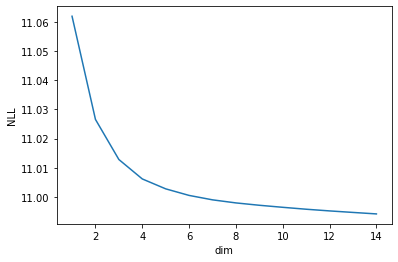

In [9]:
plt.plot(dims,losses)
plt.xlabel("dim")
plt.ylabel("NLL")
for i in dims:
    print("NMI Score dim {} = {}".format(i,nmi[i-1]))
print("\n NLL0 = {}".format(loss0))